In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import tensorflow as tf

In [3]:
def generate_batches(batch_size, features, labels):
    """
    Create batches of features and labels
    :param batch_size: The batch size
    :param features: List of features
    :param labels: List of labels
    :return: Batches of (Features, Labels)
    """
    assert len(features) == len(labels)
    outout_batches = []

    sample_size = len(features)
    for start_i in range(0, sample_size, batch_size):
        end_i = start_i + batch_size
        batch = [features[start_i:end_i], labels[start_i:end_i]]
        outout_batches.append(batch)

    return outout_batches

# 자전거 대여 횟수 예측하기

2011년에서 2012년도 미국의 워싱턴 DC의 자전거 대여 공공데이터를 사용한다.[^DCbicycle]
자료에는 날짜, 날씨, 온도, 계절, 체감온도, 풍속, 자전거 대여 횟수 등이 시간별로 기록되어 있다.

[^DCbicycle]: http://capitalbikeshare.com/system-data

> Fanaee-T, Hadi, and Gama, Joao, "Event labeling combining ensemble detectors and background knowledge", Progress in Artificial Intelligence (2013): pp. 1-15, Springer Berlin Heidelberg, doi:10.1007/s13748-013-0040-3

자전거 대여 횟수를 예측하기 위해, 신경망 모델(Neural Network Model)을 사용한 회귀(Regression) 분석을 하는 것이 이번 프로젝트의 목표이다.

## 데이터 훑어보기

제공된 `hour.csv` 파일은 다음과 같은 구조를 갖고 있다. 다음은 앞 10개의 행들이다.

| instant | dteday     | season | yr | mnth | hr | holiday | weekday | workingday | weathersit | temp | atemp  | hum  | windspeed | casual | registered | cnt | 
|---------|------------|--------|----|------|----|---------|---------|------------|------------|------|--------|------|-----------|--------|------------|-----| 
| 1       | 2011-01-01 | 1      | 0  | 1    | 0  | 0       | 6       | 0          | 1          | 0.24 | 0.2879 | 0.81 | 0         | 3      | 13         | 16  | 
| 2       | 2011-01-01 | 1      | 0  | 1    | 1  | 0       | 6       | 0          | 1          | 0.22 | 0.2727 | 0.8  | 0         | 8      | 32         | 40  | 
| 3       | 2011-01-01 | 1      | 0  | 1    | 2  | 0       | 6       | 0          | 1          | 0.22 | 0.2727 | 0.8  | 0         | 5      | 27         | 32  | 
| 4       | 2011-01-01 | 1      | 0  | 1    | 3  | 0       | 6       | 0          | 1          | 0.24 | 0.2879 | 0.75 | 0         | 3      | 10         | 13  | 
| 5       | 2011-01-01 | 1      | 0  | 1    | 4  | 0       | 6       | 0          | 1          | 0.24 | 0.2879 | 0.75 | 0         | 0      | 1          | 1   | 
| 6       | 2011-01-01 | 1      | 0  | 1    | 5  | 0       | 6       | 0          | 2          | 0.24 | 0.2576 | 0.75 | 0.0896    | 0      | 1          | 1   | 
| 7       | 2011-01-01 | 1      | 0  | 1    | 6  | 0       | 6       | 0          | 1          | 0.22 | 0.2727 | 0.8  | 0         | 2      | 0          | 2   | 
| 8       | 2011-01-01 | 1      | 0  | 1    | 7  | 0       | 6       | 0          | 1          | 0.2  | 0.2576 | 0.86 | 0         | 1      | 2          | 3   | 
| 9       | 2011-01-01 | 1      | 0  | 1    | 8  | 0       | 6       | 0          | 1          | 0.24 | 0.2879 | 0.75 | 0         | 1      | 7          | 8   | 
| 10      | 2011-01-01 | 1      | 0  | 1    | 9  | 0       | 6       | 0          | 1          | 0.32 | 0.3485 | 0.76 | 0         | 8      | 6          | 14  | 

다음 코드를 통해, `hour.csv`파일을 `pandas`의 `read_csv()`를 사용하여 `rides`라는 `DataFrame`을 얻는다.

In [4]:
data_path = 'Bike-Sharing-Dataset/hour.csv'
rides = pd.read_csv(data_path)

`rides`의 각 열별로 나타내는 정보는 다음과 같다.

* `instant`: 기록번호
* `dteday`: 날짜
* `season`: 계절 (`1`:봄, `2`:여름, `3`:가을, `4`:겨울)
* `yr`: 연도 (`0`: 2011, 1:2012)
* `mnth`: 달 (`1` ~ `12`)
* `hr`: 시간 (`0` ~ `23`)
* `holiday`: 휴일(`0`/`1`)
* `weekday`: 요일
* `workingday`: 평일(`0`/`1`)
* `weathersit`:
    * `1`: 맑거나 조금 흐림
    * `2`: 안개 및 흐림
    * `3`: 가벼운 눈, 비, 뇌우
    * `4`: 많은 비, 눈, 뇌우
* `temp`: `0`에서 `1`까지의 표준화된 섭씨 온도(최저기온 : -8, 최고기온 : 39)
* `atemp`: `0`에서 `1`까지의 표준화된 섭씨 체감온도(최저기온 : -16, 최고기온 : 50)
* `hum`: `0`에서 `1`까지 표준화된 습도(예: 0.3 = 30%)
* `windspeed`: 표준화된 풍속(최고속도 : 67)
* `casual`: 비회원의 자전거 대여횟수
* `registered`: 등록회원의 자전거 대여횟수
* `cnt`: 비회원 및 등록회원의 총 자전거 대여횟수

앞서 언급했듯이 자전거 대여 횟수를 예측하는 신경망 회귀 모델을 찾는 것이 이번 장에서의 목표이다. 대여 횟수가 총 3가지 종류가 있다. 그중에 비회원과 등록회원 모두의 자전거 대여 횟수인 `cnt`가 예측 목표이다.

다음은 첫 10일의 데이터를 날짜/총대여량을 나타내주는 그래프이다. 아주 이른 새벽에는 대여량이 급격히 줄어드는 것을 볼 수 있다. 신경망 모델을 통해 아래 그래프와 비슷한 예측 그래프를 확보할 수 있다. 

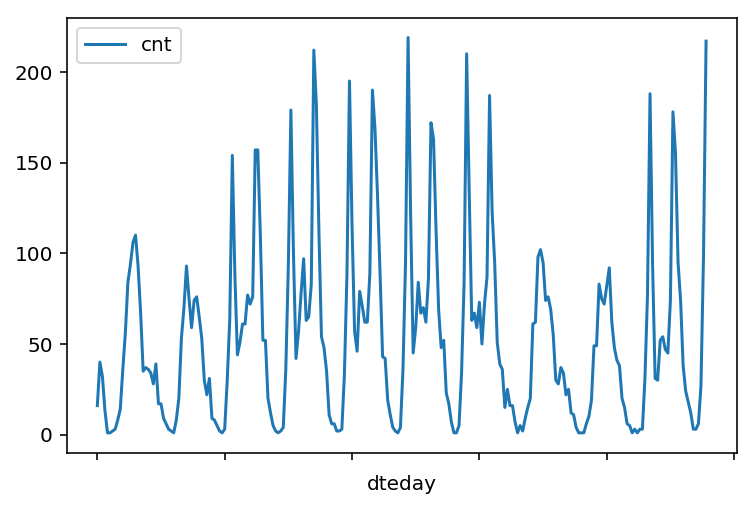

In [5]:
rides[:24*10].plot(x='dteday', y='cnt')

## 데이터 정돈하기
### Dummy 변수 도입하기

In [6]:
print("Before applying dummy variables : ")
print(sorted(rides.columns.values))
dummy_fields = ['season', 'weathersit','mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

print("")
print("After applying dummy variables : ")
print(sorted(rides.columns.values))

Before applying dummy variables : 
['atemp', 'casual', 'cnt', 'dteday', 'holiday', 'hr', 'hum', 'instant', 'mnth', 'registered', 'season', 'temp', 'weathersit', 'weekday', 'windspeed', 'workingday', 'yr']

After applying dummy variables : 
['atemp', 'casual', 'cnt', 'dteday', 'holiday', 'hr', 'hr_0', 'hr_1', 'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19', 'hr_2', 'hr_20', 'hr_21', 'hr_22', 'hr_23', 'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9', 'hum', 'instant', 'mnth', 'mnth_1', 'mnth_10', 'mnth_11', 'mnth_12', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'registered', 'season', 'season_1', 'season_2', 'season_3', 'season_4', 'temp', 'weathersit', 'weathersit_1', 'weathersit_2', 'weathersit_3', 'weathersit_4', 'weekday', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'windspeed', 'workingday', 'yr']


### 주요 Feature 선택하기

주요한 핵심 요소들만 추려서 모델을 만드는 것이 좋다.
다음 코드는 앞서 제거하기로 결정한 5가지 항목에 대해서 `df.drop()`을 사용하여 해당 열을 지우는 코드이다.

In [7]:
fields_to_drop = ['instant', 'dteday', 'season', 'atemp', 'workingday']
data = rides.drop(fields_to_drop, axis=1)
print(sorted(rides.columns.values))

['atemp', 'casual', 'cnt', 'dteday', 'holiday', 'hr', 'hr_0', 'hr_1', 'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19', 'hr_2', 'hr_20', 'hr_21', 'hr_22', 'hr_23', 'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9', 'hum', 'instant', 'mnth', 'mnth_1', 'mnth_10', 'mnth_11', 'mnth_12', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'registered', 'season', 'season_1', 'season_2', 'season_3', 'season_4', 'temp', 'weathersit', 'weathersit_1', 'weathersit_2', 'weathersit_3', 'weathersit_4', 'weekday', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'windspeed', 'workingday', 'yr']


### 데이터 표준화 하기

In [8]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Train/Test/Validation 나누기

In [9]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

In [10]:
train_features, train_targets = features, targets
print(train_features.shape, train_targets.shape)
# print(train_targets)

(16875, 62) (16875, 1)


In [ ]:
import csv

with open('thefile.csv', 'rb') as f:
  data = list(csv.reader(f))

import collections
counter = collections.defaultdict(int)
for row in data:
    counter[row[0]] += 1


writer = csv.writer(open("/path/to/my/csv/file", 'w'))
for row in data:
    if counter[row[0]] >= 4:
        writer.writerow(row)

## 프로젝트 목표

* `curr_loss`값이 `0.05` 밑으로 내려가는 것을 목표로 한다. 

Hyper-Parameter 조정을 하며 최적의 모델을 찾아낸다.

1. Learning Rate
1. Optimizer
1. batch size
1. Max Epochs
1. 그외 모델 관련 Parameters

## 신경망 모델 만들기(TODO1)

신경망 모델에는 다음과 같은 Hyper-Parameter들이 존재한다.

1. Layer 갯수 : 최대 4개 이하 권장
1. Node 갯수
1. activation 함수 : sigmoid / relu

적당한 값일 잘 선택하여 `curr_loss`를 0.05 밑으로만 내려가게 하면 된다.

In [11]:
# TODO 1
x = tf.placeholder(tf.float32, [None, features.shape[1]])
y = tf.placeholder(tf.float32, [None, 1])

num_hidden1 = 150
num_hidden2 = 100

# num_hidden3 = 50

hidden1 = tf.layers.dense(x, units=num_hidden1, use_bias=True, activation=tf.nn.sigmoid)
hidden2 = tf.layers.dense(hidden1, units=num_hidden2, use_bias=True, activation=tf.nn.sigmoid)
# hidden3 = tf.layers.dense(hidden2, units=num_hidden3, use_bias=True, activation=tf.nn.sigmoid)
output = tf.layers.dense(hidden2, units=1, use_bias=True, activation=tf.nn.tanh)


## 비용 함수 정의하기

In [12]:
loss = tf.losses.mean_squared_error(y, output)

## Stochastic Gradient Descent(TODO2)

In [13]:
# TODO 2
lr = 0.01
train = tf.train.AdagradOptimizer(lr).minimize(loss)
batch_size = 200
MaxEpochs = 500

# Shuffling
idx = np.arange(len(features))
np.random.shuffle(idx)
shuffled_features = features.values[idx]
shuffled_labels = targets['cnt'].values[idx].reshape(-1,1)

# SGD
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
for epoch in range(MaxEpochs):
    for x_batch, y_batch in generate_batches(batch_size, shuffled_features, shuffled_labels):
        sess.run(train, feed_dict={x: x_batch, y:y_batch})
    if epoch % 100 == 0:
        curr_loss = sess.run(loss, feed_dict={x: shuffled_features, y:shuffled_labels})
        print(epoch, curr_loss)

0 0.67353064
100 0.20784189
200 0.20699863
300 0.20662029
400 0.2063689


In [14]:
'''Results
# Optimizer/Hidden Layer & Func./Hidden Node/Output Func./Learning Rate/Batch Size/Max Epoch/Loss #
    * Adam / 1~3(Sig) / (100 ~ 150, 100 ~ 150) / Sig / 0.01 ~ 0.001 / 200 / 5000 / 0.45... ~ 0.5...
    * Adagrad / 2(Sig, Sig) / (100, 100) / Tanh / 0.01 / 200 / 5000 / 0.200...
    * Adagrad / 2(Sig, Sig) / (100, 100) / Tanh / 0.001 / 200 / 5000 / 0.199
    * Adam / 2(Sig, Sig) / (100, 100) / Tanh / 0.01 / 200 / 5000 / 0.199...
    * Adam / 2(Sig, Sig) / (100, 100) / Tanh / 0.001 / 200 / 5000 / 0.199...
    * Adam / 2(Sig, Sig) / (150, 100) / Tanh / 0.1 / 200 / 5000 / 2.023...
    * Adam / 2(Sig, Sig) / (150, 100) / Tanh / 0.01 / 200 / 5000 / 0.199...
    * Adam / 2(Sig, Sig) / (150, 100) / Tanh / 0.001 / 200 / 5000 / 0.199...
'''

'''Question
상기 기재한 내용들 이외에도 하이퍼파라미터 튜닝을 많이 시도해봤습니다만... 0.05까지는 Loss가 안떨어지네요 ㅠㅠ
Epoch 수를 늘려도 5000 이상이 되면 거의 발산하는 것을 확인하였습니다.

어느 부분이 부족했을까요?

'''

'Question\n상기 기재한 내용들 이외에도 하이퍼파라미터 튜닝을 많이 시도해봤습니다만... 0.05까지는 Loss가 안떨어지네요 ㅠㅠ\nEpoch 수를 늘려도 5000 이상이 되면 거의 발산하는 것을 확인하였습니다.\n\n어느 부분이 부족했을까요?\n\n'

## 모델의 예측값 정확도

다음 그림과 비슷하게 나와야 한다.

![](an_answer.svg)

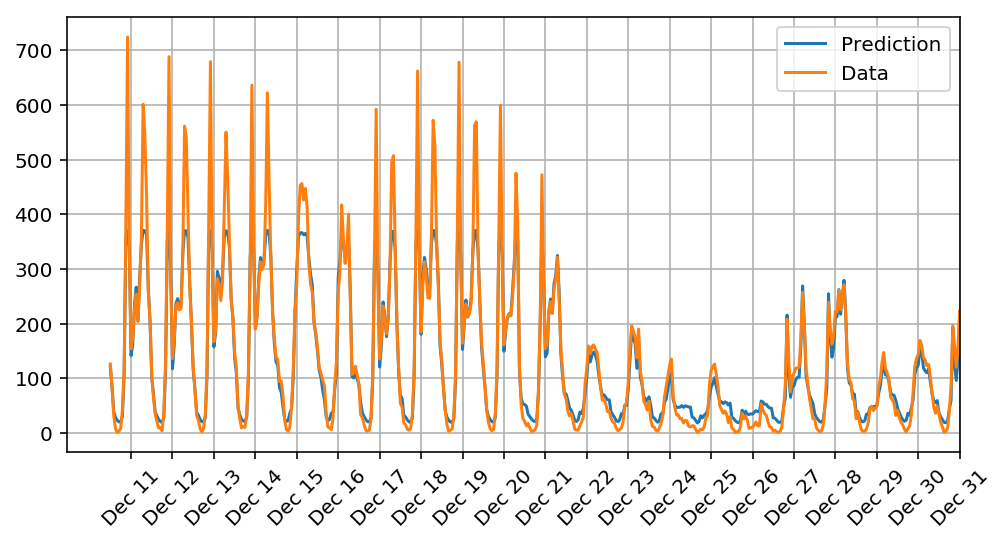

In [15]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions= sess.run(output, feed_dict={x: test_features, y:test_targets['cnt'].values.reshape(-1,1)})
predictions = predictions.T * std + mean

ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)
ax.grid()